## Vimeo OTT - Free Trial Conversion Predictor

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
import random
import pdb
import time
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/villarreala/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Cleaning

In [2]:
free_trials = pd.read_csv('/Users/villarreala/Desktop/free_trials.csv', low_memory=False)
video_events = pd.read_csv('/Users/villarreala/Desktop/video_events.csv', low_memory=False)

In [3]:
free_trials.user_id = free_trials.user_id.astype(int)

In [4]:
data = free_trials.merge(video_events,how='left',on='user_id')
data.head()

,user_id,user_created,city,state,country,country_code,ticket_id,ticket_created,platform,free_trial_days,site_id,top_site,promo_used,converted,time_watched,views_started,views_finished,video_count
0,3519638,10/24/17 18:00,Quaregnon,3,Belgium,be,3183208,10/24/17 18:00,web,30,69,0,0,0,97.2,4.0,3.0,4.0
1,3575908,11/10/17 23:02,Selje,15,Norway,no,3238724,11/10/17 23:02,ios,30,24335,1,0,1,169.3,26.0,16.0,24.0
2,3575919,11/10/17 23:06,Baldwin Park,CA,United States,us,3238735,11/10/17 23:06,ios,30,24335,1,0,1,122.3,21.0,12.0,19.0
3,3575954,11/10/17 23:17,Mansfield,TX,United States,us,3238774,11/10/17 23:17,ios,30,24335,1,0,1,8.5,1.0,1.0,1.0
4,3575862,11/10/17 22:49,(null),(null),Germany,de,3238676,11/10/17 22:49,ios,30,24335,1,0,1,916.8,68.0,46.0,52.0


In [5]:
###to_numeric
data.free_trial_days = pd.to_numeric(data.free_trial_days)
data.time_watched = pd.to_numeric(data.time_watched)
data.views_started = pd.to_numeric(data.views_started)
data.converted = pd.to_numeric(data.converted)
data.views_finished = pd.to_numeric(data.views_finished)
data.promo_used = pd.to_numeric(data.promo_used)

###Create dummies & new descriptive features
data["domestic"] = data.country == "United States"
data["completion_rate"] = data.views_finished/data.views_started
data["is_web"] = data.platform == "web"
data["week_ft"] = data.free_trial_days == 7
data['daily_view_time'] = data.time_watched / data.free_trial_days
data["daily_view_log"] = np.log10(data.daily_view_time + .0001)

###Replace null values
data.time_watched.replace(np.NaN, 0, inplace=True)
data.views_started.replace(np.NaN, 0, inplace=True)
data.views_finished.replace(np.NaN, 0, inplace=True)
data.video_count.replace(np.NaN, 0, inplace=True)
data.converted.replace(np.NaN, 0, inplace = True)
data.completion_rate.replace(np.NaN, 0, inplace = True)
data.completion_rate.replace(np.inf, 0, inplace = True)
data.daily_view_time.replace(np.inf, 0, inplace = True)
data.daily_view_time.replace(np.NaN, 0, inplace = True)
data.daily_view_log.replace(np.NaN, 0, inplace = True)
data.daily_view_log.replace(np.inf, 0, inplace = True)

data.head()

,user_id,user_created,city,state,country,country_code,ticket_id,ticket_created,platform,free_trial_days,...,time_watched,views_started,views_finished,video_count,domestic,completion_rate,is_web,week_ft,daily_view_time,daily_view_log
0,3519638,10/24/17 18:00,Quaregnon,3,Belgium,be,3183208,10/24/17 18:00,web,30,...,97.2,4.0,3.0,4.0,False,0.750000,True,False,3.240000,0.510558
1,3575908,11/10/17 23:02,Selje,15,Norway,no,3238724,11/10/17 23:02,ios,30,...,169.3,26.0,16.0,24.0,False,0.615385,False,False,5.643333,0.751543
2,3575919,11/10/17 23:06,Baldwin Park,CA,United States,us,3238735,11/10/17 23:06,ios,30,...,122.3,21.0,12.0,19.0,True,0.571429,False,False,4.076667,0.610316
3,3575954,11/10/17 23:17,Mansfield,TX,United States,us,3238774,11/10/17 23:17,ios,30,...,8.5,1.0,1.0,1.0,True,1.000000,False,False,0.283333,-0.547549
4,3575862,11/10/17 22:49,(null),(null),Germany,de,3238676,11/10/17 22:49,ios,30,...,916.8,68.0,46.0,52.0,False,0.676471,False,False,30.560000,1.485155


In [6]:
###remove all outliers

from scipy import stats

int_cols = ['time_watched','views_started','views_finished','video_count']

data = data[(np.abs(stats.zscore(data[int_cols])) < 3).all(axis=1)]

data = data[data['completion_rate'] < 1]
data = data[data['free_trial_days'] > 0]

In [7]:
data.describe()

,user_id,ticket_id,free_trial_days,site_id,top_site,promo_used,converted,time_watched,views_started,views_finished,video_count,completion_rate,daily_view_time,daily_view_log
count,1.065640e+05,1.065640e+05,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000,106564.000000
mean,3.212299e+06,2.919918e+06,14.470093,24924.950396,0.682153,0.068710,0.646297,92.970575,11.881057,4.730369,7.686433,0.280174,11.222804,0.412772
std,4.723717e+05,3.805831e+05,11.681175,3822.714282,0.465642,0.252961,0.478121,138.219196,16.736822,7.691658,9.568351,0.276334,19.235377,1.072152
min,1.150000e+02,2.289482e+06,3.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000
25%,2.872903e+06,2.533106e+06,7.000000,22104.000000,0.000000,0.000000,0.000000,2.200000,2.000000,0.000000,1.000000,0.000000,0.176667,0.000000
50%,3.362512e+06,3.047205e+06,7.000000,24335.000000,1.000000,0.000000,1.000000,39.300000,6.000000,2.000000,4.000000,0.250000,3.500000,0.544080
75%,3.606211e+06,3.274778e+06,30.000000,28302.000000,1.000000,0.000000,1.000000,123.500000,15.000000,6.000000,10.000000,0.500000,13.366667,1.126026
max,3.714391e+06,3.391733e+06,31.000000,36858.000000,1.000000,1.000000,1.000000,922.700000,122.000000,59.000000,59.000000,0.982456,298.000000,2.474216


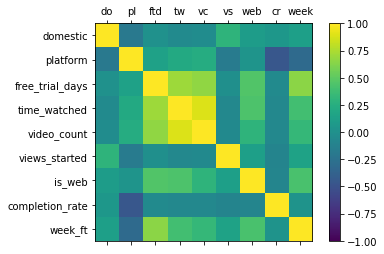

In [8]:
names = ['domestic','platform','free_trial_days','time_watched','video_count','views_started','is_web','completion_rate','week_ft','daily_view_time']
names2 = ['do','pl','ftd','tw','vc','vs','web','cr','week','dvt']
data1 = data[['domestic','platform','free_trial_days','time_watched','video_count','views_started','is_web','completion_rate','week_ft','daily_view_time']].copy()
correlations = data1.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names2)
ax.set_yticklabels(names)
plt.show()

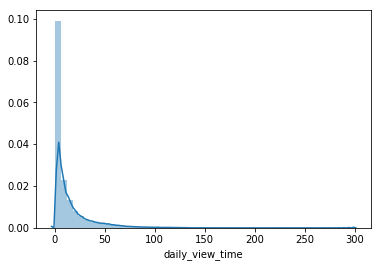

In [13]:
sns.distplot(data.daily_view_time)

In [11]:
data["completion_log"] = np.log10(data.completion_rate + .0001)
data["views_started_log"] = np.log10(data.views_started + .0001)
data["views_finished_log"] = np.log10(data.views_finished + .0001)
data["video_count_log"] = np.log10(data.video_count + .0001)

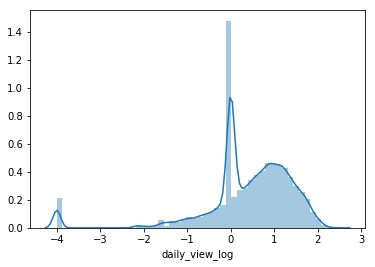

In [14]:
sns.distplot(data.daily_view_log)

### Logistic Regression

In [15]:
features = ['domestic','promo_used','completion_log','top_site','week_ft','daily_view_log','views_started_log','views_finished_log','video_count_log']
X, y = data[features], data.converted

In [16]:
model = LogisticRegression(fit_intercept = True)
cross_val_score(model, X, y, cv=10).mean()

0.67447692050748442

In [17]:
model.fit(X, y)
print model.predict(X)[:5]
print model.predict_proba(X)[:5]

[1 1 1 1 1]
[[ 0.4098892   0.5901108 ]
 [ 0.36671008  0.63328992]
 [ 0.23668362  0.76331638]
 [ 0.33162334  0.66837666]
 [ 0.39581224  0.60418776]]


In [18]:
y_pred = np.array(zip(*model.predict_proba(X))[1])
y_pred[:10]

array([ 0.5901108 ,  0.63328992,  0.76331638,  0.66837666,  0.60418776,
        0.4307927 ,  0.60354262,  0.74260028,  0.7530546 ,  0.77651059])

In [19]:
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print "%-10s: %.4f" % (metric, cross_val_score(model, X, y, cv=10, scoring=metric).mean())

accuracy  : 0.6745
precision : 0.6957
recall    : 0.9025
f1        : 0.7814
roc_auc   : 0.6431


A cross validation score of .67 isn't terrible, but the high recall makes me question whether my model is overfitting (roughly 2/3 of my dataset represents converted users). I'd continue to take a look at Random Forest & Boosting Forest models.

### Random Forest

In [20]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = 3)
cross_val_score(model, X, data.converted).mean()

0.58994497000492863

In [21]:
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print "%-10s: %.4f" % (metric, cross_val_score(model, X, y, cv=10, scoring=metric).mean())

accuracy  : 0.6788
precision : 0.6925
recall    : 0.9192
f1        : 0.7866
roc_auc   : 0.6374


### Boosting Forest

In [22]:
features = ['domestic','promo_used','completion_log','top_site','week_ft','daily_view_log','views_started_log','views_finished_log','video_count_log']
X, y = data[features], data.converted

In [23]:
%%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()
        model = RandomForestClassifier(n_estimators=n, criterion=criterion)
        accuracy = cross_val_score(model, X, data.converted).mean()
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores = pd.DataFrame(scores)

CPU times: user 1min 51s, sys: 5.22 s, total: 1min 56s
Wall time: 2min


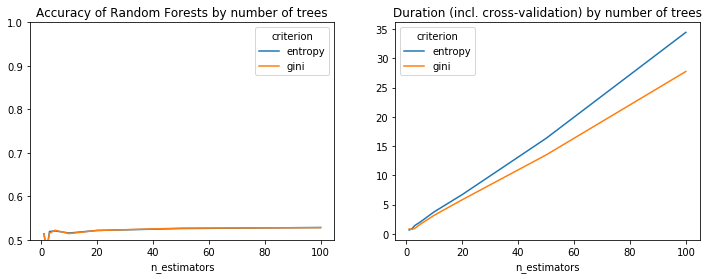

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
f = scores.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Random Forests by number of trees", ax=axes[0])
f = scores.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1]) 

In [25]:
####via GradeintBoosting
model = GradientBoostingClassifier(n_estimators=10,max_depth = 4)
cross_val_score(model, X, data.converted).mean()

0.58690457661618545

In [26]:
####via AdaBoost
model = AdaBoostClassifier(n_estimators=10)
cross_val_score(model, X, data.converted).mean()

0.56869052662256481

My Random Forest & Boosting Forest models performed even worse! However, I'd like to take a stab at optimizing my parameters to see if I can improve performance. For this, I will use sklearn's GridSearch function, which will allow me identify the optimal ranges for each parameter.

### Random Forest Parameter Optimization

In [35]:
model = RandomForestClassifier(random_state = 84)
features = ['domestic','promo_used','completion_log','top_site','week_ft','daily_view_log','views_started_log','views_finished_log','video_count_log']

In [36]:
from sklearn.grid_search import GridSearchCV

def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(model, param_grid = {parameter: num_range})
    grid_search.fit(X, y)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

In [37]:
param_grid = {"n_estimators": np.arange(2, 300, 2),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

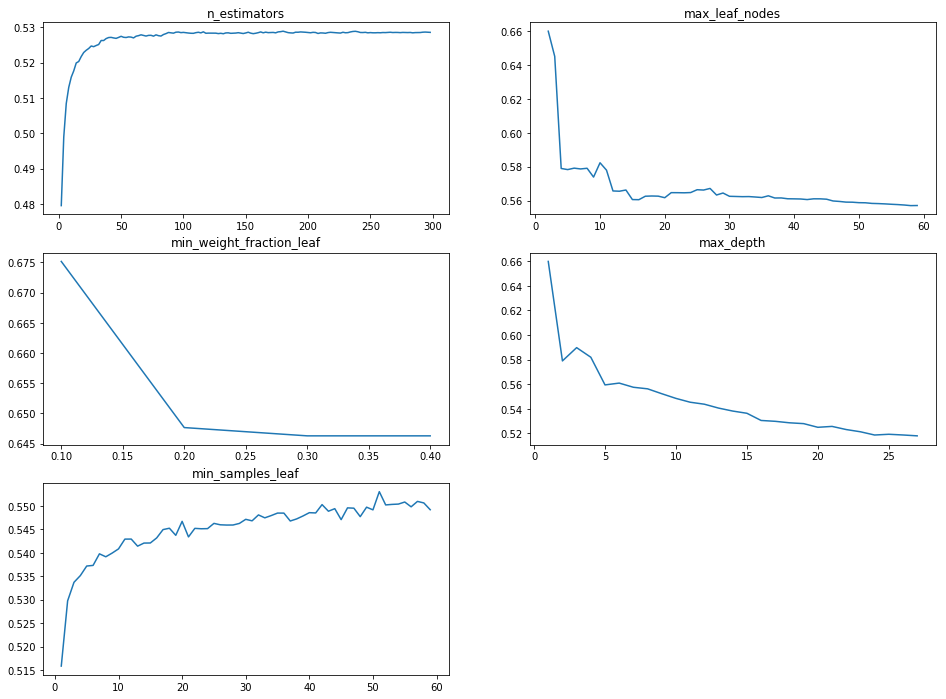

In [38]:
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1

Now that I have the above graphs, I can make more educated guesses on my parameters. I will now iterate through a few values for each parameter and see which combination performs the best.

In [39]:
from operator import itemgetter

def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [44]:
# parameters for GridSearchCV
param_grid2 = {"n_estimators": [50,60],
              "max_depth": [2, 3, 4],
              "min_samples_leaf": [50,52],
              "max_leaf_nodes": [None],
              "min_weight_fraction_leaf": [0.1]}

In [45]:
grid_search = GridSearchCV(model, param_grid=param_grid2)
grid_search.fit(X, y)

report(grid_search.grid_scores_, 4)

Model with rank: 1
Mean validation score: 0.6761)
Parameters: {'n_estimators': 60, 'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0.1, 'max_depth': 3, 'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.6761)
Parameters: {'n_estimators': 60, 'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0.1, 'max_depth': 3, 'min_samples_leaf': 52}

Model with rank: 3
Mean validation score: 0.6760)
Parameters: {'n_estimators': 60, 'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}

Model with rank: 4
Mean validation score: 0.6760)
Parameters: {'n_estimators': 60, 'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0.1, 'max_depth': 4, 'min_samples_leaf': 52}



In [49]:
# parameters for GridSearchCV
param_grid2 = {"n_estimators": [50,55],
              "max_depth": [2],
              "min_samples_leaf": [50,52],
              "max_leaf_nodes": [2],
              "min_weight_fraction_leaf": [0.1]}

In [50]:
grid_search = GridSearchCV(model, param_grid=param_grid2)
grid_search.fit(X, y)

report(grid_search.grid_scores_, 4)

Model with rank: 1
Mean validation score: 0.6463)
Parameters: {'n_estimators': 50, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.6463)
Parameters: {'n_estimators': 55, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 50}

Model with rank: 3
Mean validation score: 0.6463)
Parameters: {'n_estimators': 50, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 52}

Model with rank: 4
Mean validation score: 0.6463)
Parameters: {'n_estimators': 55, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 52}



In [55]:
# parameters for GridSearchCV
param_grid2 = {"n_estimators": [90,100],
              "max_depth": [2],
              "min_samples_leaf": [50,52],
              "max_leaf_nodes": [2],
              "min_weight_fraction_leaf": [0.1]}

In [56]:
grid_search = GridSearchCV(model, param_grid=param_grid2)
grid_search.fit(X, y)

report(grid_search.grid_scores_, 4)

Model with rank: 1
Mean validation score: 0.6463)
Parameters: {'n_estimators': 90, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.6463)
Parameters: {'n_estimators': 100, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 50}

Model with rank: 3
Mean validation score: 0.6463)
Parameters: {'n_estimators': 90, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 52}

Model with rank: 4
Mean validation score: 0.6463)
Parameters: {'n_estimators': 100, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.1, 'max_depth': 2, 'min_samples_leaf': 52}



After cycling through a few parameter combinations, the below parameters seem to perform just slightly higher than my logistic regression. Since I felt overfitting was an issue with my logisitc regression as well, I'd like to stick with this random forest to reduce that risk.

In [53]:
model = RandomForestClassifier(n_estimators = 60, max_leaf_nodes = None, min_weight_fraction_leaf = 0.1, max_depth = 3, min_samples_leaf = 50)
cross_val_score(model, X, data.converted).mean()

0.66135857403087794

In [54]:
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print "%-10s: %.4f" % (metric, cross_val_score(model, X, y, cv=10, scoring=metric).mean())

accuracy  : 0.6749
precision : 0.6939
recall    : 0.9170
f1        : 0.7864
roc_auc   : 0.6334
